<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<center>
<H1 align='center'> INF-395 Redes Neuronales Artificiales 2019-1</H1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
</center>
<hr style="height:2px;border:none"/>

## Integrantes

* _**Francisco Olivares - 201473575-8 - fracisco.olivars.14@sansano.usm.cl**_
* _**Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl**_



<hr style="height:2px;border:none"/>

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
#Keras
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Flatten, Dense, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model

#sklearn
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")


> _**a) Normalice las imágenes de modo que los pixeles queden en el rango [0, 1] como se acostumbra al trabajar con imágenes. Visualice y comente sobre los datos a trabajar.**_

In [63]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:,:,:,None]
x_test = x_test[:,:,:,None]
img_rows, img_cols,channel = x_train.shape[1:]
original_img_size = (img_rows,img_cols,channel)

In [64]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [65]:
def show_9_random_images(dataset,labels):
    plt.figure(figsize=(12,12))
    for i in range(1,10):
        plt.subplot(3,3,i)
        random_index = np.random.randint(0,dataset.shape[0])
        plt.title("Label image %s" %labels[random_index])
        plt.imshow(dataset[random_index][:,:,0],cmap='gray')
        
    plt.show()    
        

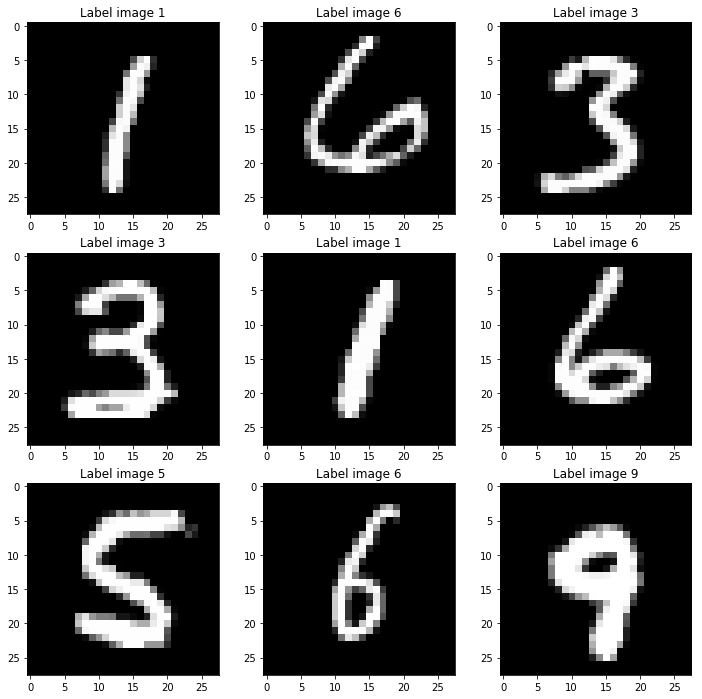

In [66]:
show_9_random_images(x_train,y_train)

## Autoencoder clásico

> _**a) Entrene un AE básico, 1 capa escondida feed forward, para generar una representación de MNIST en  $d^{'}=2,8,16,32$  dimensiones. Justifique la elección de la función de pérdida a utilizar y del criterio de entrenamiento en general. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. ¿Mejora el resultado si elegimos una función de activación ReLU para el Encoder? ¿Podrı́a utilizarse esta activación en el Decoder?**_

In [67]:
def get_basic_autoencoder(compres_dim=2,activation_encoder='sigmoid',activation_decoder='sigmoid',loss='binary_crossentropy'):
    input_img = Input(shape=original_img_size)
    flatten_input = Flatten()(input_img)
    encoder = Dense(compres_dim,activation=activation_encoder)(flatten_input)
    decoder = Dense(np.prod(original_img_size),activation=activation_decoder)(encoder)
    decoder = Reshape(original_img_size)(decoder)
    autoencoder = Model(inputs=input_img,outputs=decoder)
    autoencoder.compile(optimizer='rmsprop',loss=loss)
    encoder = Model(inputs=input_img,outputs=encoder)
    test_loss = autoencoder.fit(x_train,x_train,epochs=40,batch_size=32,verbose=0,validation_data=(x_test,x_test)).history['val_loss']
    return autoencoder, encoder, test_loss

def train_and_save_autoencoders(dimension_list,activation_encoder,activation_decoder,loss):
    hist_list = []
    for i in dimension_list:
        autoencoder, encoder, test_loss = get_basic_autoencoder(compres_dim=i,activation_encoder=activation_encoder,activation_decoder=activation_decoder,loss=loss)
        hist_list.append(test_loss)
        autoencoder.save('autoencoders/basic_autoencoders/%s/%s_autoencoder_d%s.h5' % (loss,activation_encoder,i))
        encoder.save('autoencoders/basic_autoencoders/%s/%s_encoder_d%s.h5' % (loss,activation_encoder,i))
    return hist_list
        

###### Usando Binary Crossentropy 

In [68]:
dimension_list = [2,8,16,32]
#Run only one time c:

In [8]:
#NO CORRER
autoencoder_hist_list = train_and_save_autoencoders(dimension_list,'sigmoid','sigmoid','binary_crossentropy')

In [9]:
#NO CORRER
autoencoder_hist_list_relu = train_and_save_autoencoders(dimension_list,'relu','sigmoid','binary_crossentropy')

##### Usando Mean Squared Error

In [10]:
#NO CORRER
autoencoder_hist_list_mse = train_and_save_autoencoders(dimension_list,'sigmoid','sigmoid','mean_squared_error')

In [11]:
#NO CORRER
autoencoder_hist_list_mse_relu = train_and_save_autoencoders(dimension_list,'relu','sigmoid','mean_squared_error')

###### Guardamos las historias en dos diccionarios

In [12]:
#NO CORRER
AE_sigmoid_dict = {
    'binary_crossentropy':autoencoder_hist_list,
    'mean_squared_error':autoencoder_hist_list_mse
}
AE_relu_dict = {
    'binary_crossentropy':autoencoder_hist_list_relu,
    'mean_squared_error':autoencoder_hist_list_mse_relu
}

In [13]:
#NO CORRER
with open('autoencoders/basic_autoencoders/hist_dicts/AE_sigmoid_dict.sav','wb') as handler:
    pickle.dump(AE_sigmoid_dict, handler)

In [14]:
#NO CORRER
with open('autoencoders/basic_autoencoders/hist_dicts/AE_relu_dict.sav','wb') as handler:
    pickle.dump(AE_relu_dict, handler)

##### Cargar las historias

In [8]:
pickle_in = open("autoencoders/basic_autoencoders/hist_dicts/AE_sigmoid_dict.sav","rb")
pickle_in_relu =  open("autoencoders/basic_autoencoders/hist_dicts/AE_relu_dict.sav","rb")
AE_sigmoid_dict = pickle.load(pickle_in)
AE_relu_dict = pickle.load(pickle_in_relu)
pickle_in.close()
pickle_in_relu.close()

###### Error de reconstrucción

In [9]:
def reconstruction_error_plot(dim_list, activation_encoder, hist_dict, hist_dict_relu):
    plt.figure(figsize=(15,7))
    counter = 1
    #marker_list = ['-o','-*','-h','-s']
    for loss in hist_dict.keys():
        plt.subplot(1,2,counter)
        plt.title("Reconstruction error using %s" %loss,fontsize=18)
        plt.xlabel("error",fontsize=15)
        plt.ylabel("Dimension",fontsize=15)
        hist_list = hist_dict[loss]
        hist_list_relu = hist_dict_relu[loss]
        val_loss_list = list()
        val_loss_list_relu = list()
        for index in range(len(dim_list)):
            val_loss_list.append(hist_list[index][-1])
            val_loss_list_relu.append(hist_list_relu[index][-1])
        plt.barh(dim_list,val_loss_list,0.5,color='lightcoral',label="Sigmoid",tick_label=['2','8','16','32'])
        plt.barh(list(map(lambda x : x - 0.5,dim_list)),val_loss_list_relu,0.5,color='skyblue',label="Relu",tick_label=['2','8','16','32'])
        counter += 1
    #plt.legend(['Binary Crossentropy','MSE'])
        plt.yticks([1.75,3.75,5.75,7.75])
        plt.legend(loc="upper right")
    plt.show()

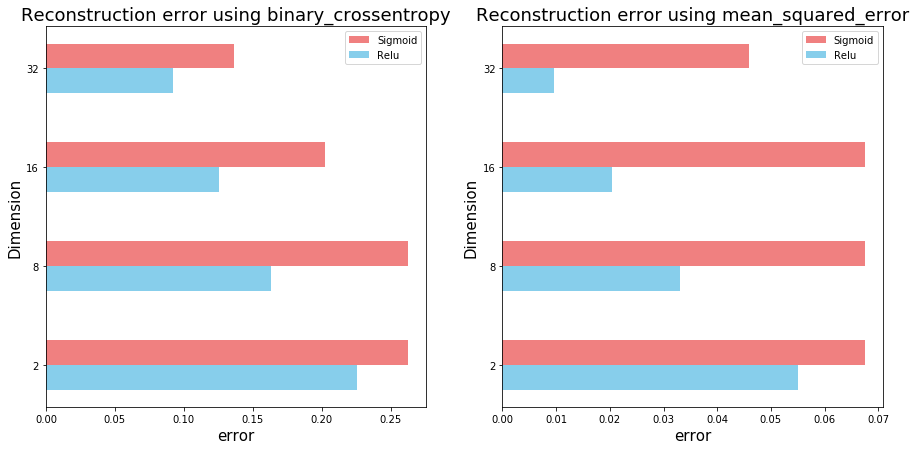

In [10]:
reconstruction_error_plot([2,4,6,8],'sigmoid',AE_sigmoid_dict,AE_relu_dict)

In [11]:
def compression_plot(dim_list,activation_encoder,loss):
    comp_size_list = []
    for dim in dim_list:
        encoder = load_model("autoencoders/basic_autoencoders/%s/%s_encoder_d%s.h5" % (loss,activation_encoder,dim))
        predict = encoder.predict(x_test)
        comp_size_list.append(1 - predict[0].nbytes/x_test[0].nbytes)
    plt.figure(figsize=(15,7))
    plt.title("Compression Rates")
    plt.ylabel("Compression rate in bytes")
    plt.xlabel("Compression dimension")
    plt.plot(list(map(str,dim_list)),comp_size_list,'o')
    plt.show()
    
    

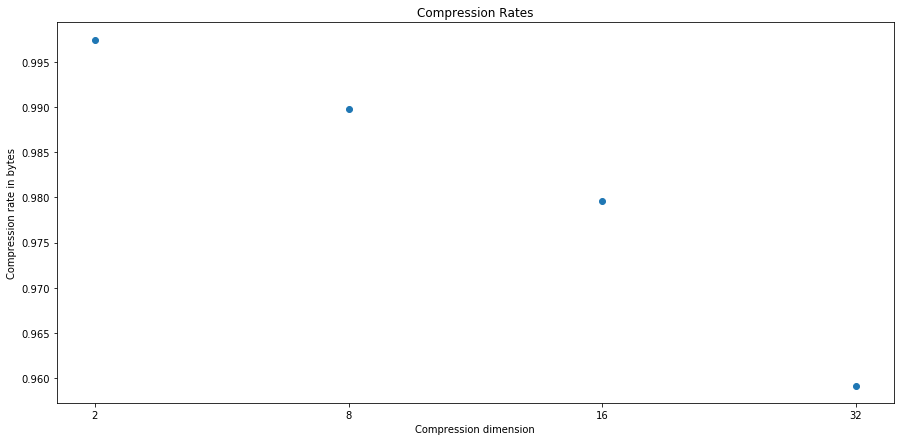

In [12]:
compression_plot(dimension_list,'relu','binary_crossentropy')

> _**b) Compare visualmente la reconstrucción que logra hacer el autoencoder desde la representación en ${\rm I\!R}^{d'}$ para algunas imágenes del conjunto de pruebas. Determine si la percepción visual se corresponde con el error de reconstrucción observada. Comente.**_

In [13]:
def comparison_plot(n_images,x_test,decoded_test,compres_dim,activation,loss):
    plt.figure(figsize=(20,4))
    for i in range(n_images):
        ax = plt.subplot(2,n_images,i+1)
        plt.title("Original Image")
        plt.imshow(x_test[i].reshape(28,28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2,n_images,i+1+n_images)
        plt.title("Decoded Image with %s dimensions, %s activation and %s loss" % (compres_dim, activation,loss))
        plt.imshow(decoded_test[i].reshape(28,28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def load_and_plot_comparison(dim_list,activation,loss,n_images):
    for dim in dim_list:
        autoencoder_model = load_model("autoencoders/basic_autoencoders/%s/%s_autoencoder_d%s.h5" % (loss,activation,dim))
        autoencoder_predict = autoencoder_model.predict(x_test)
        comparison_plot(n_images,x_test,autoencoder_predict,dim,activation,loss)

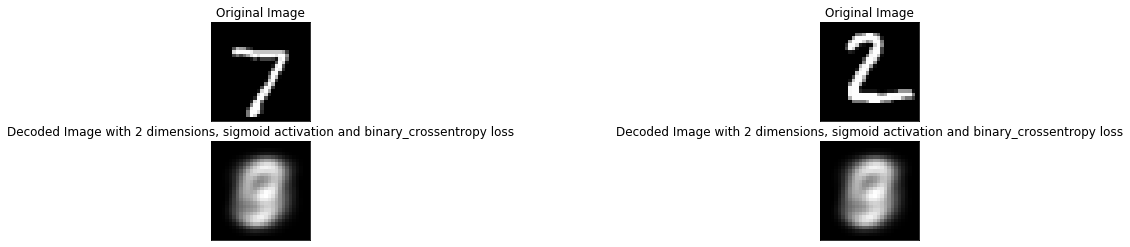

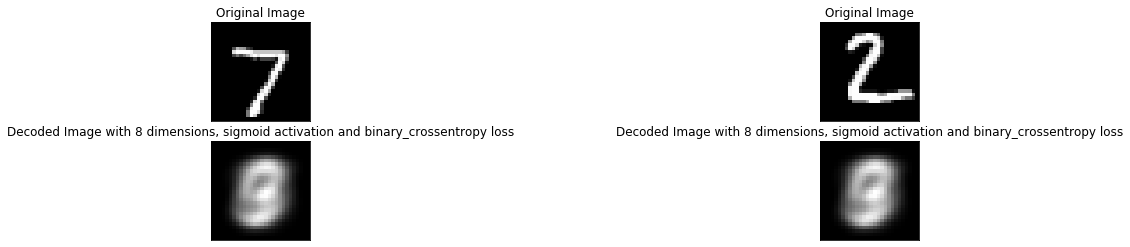

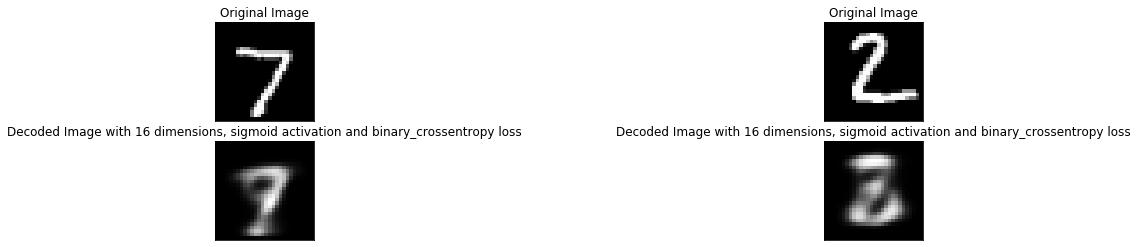

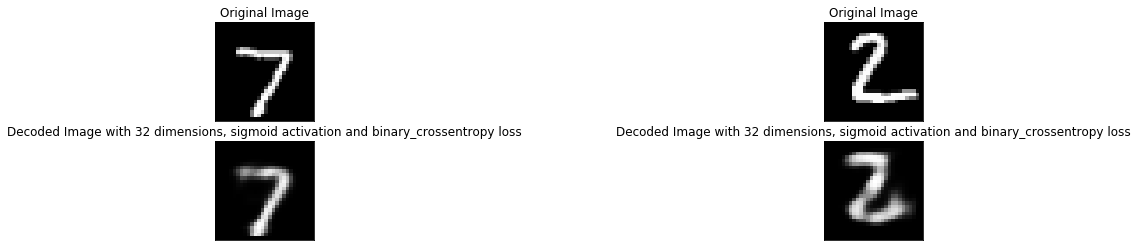

In [14]:
load_and_plot_comparison(dimension_list,'sigmoid','binary_crossentropy',2)

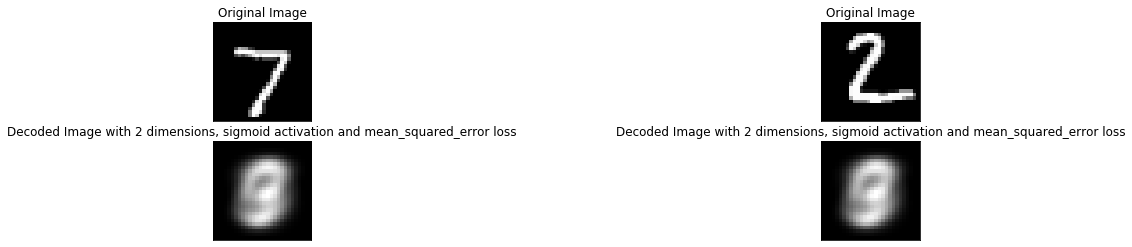

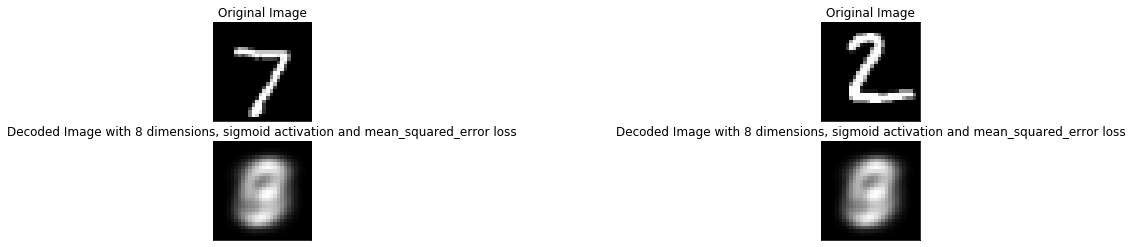

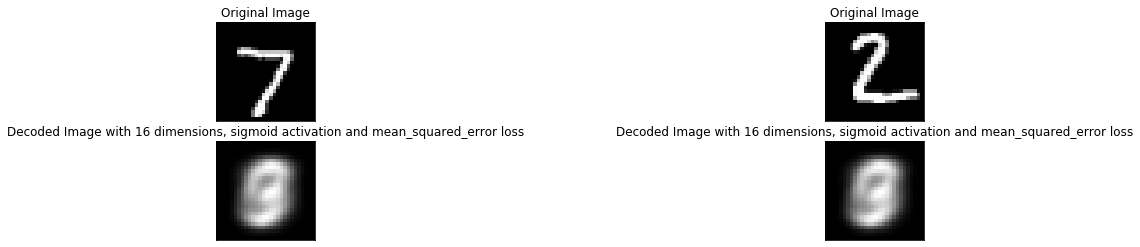

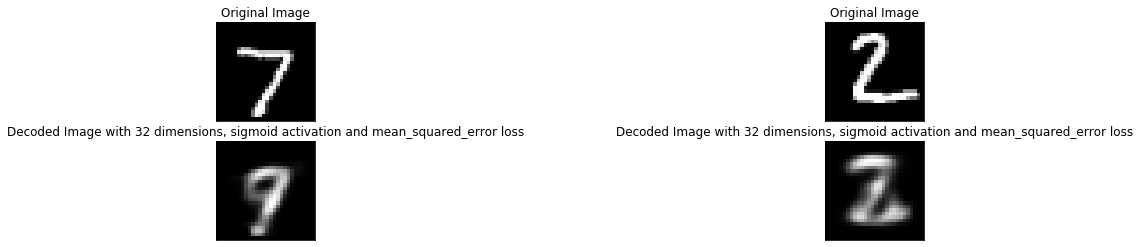

In [15]:
load_and_plot_comparison(dimension_list,'sigmoid','mean_squared_error',2)

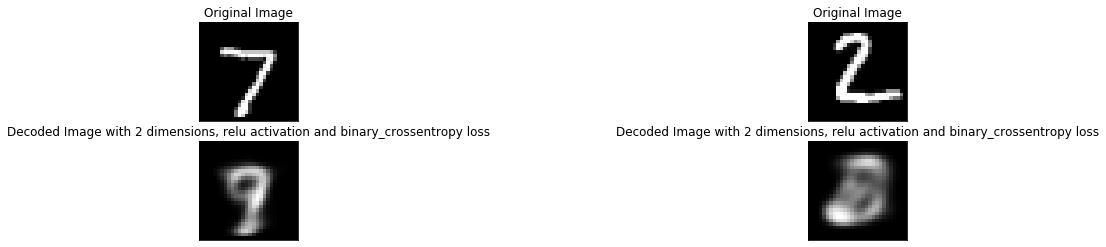

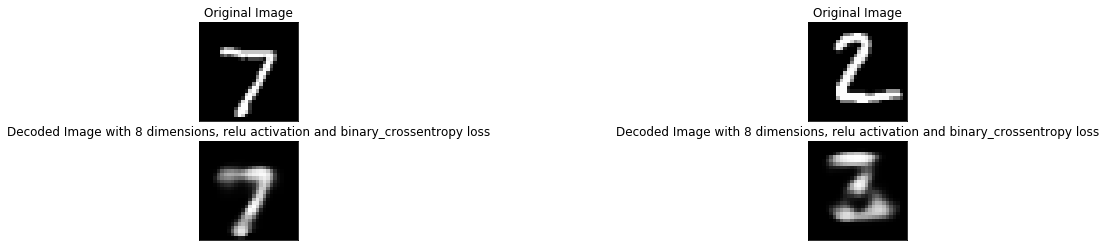

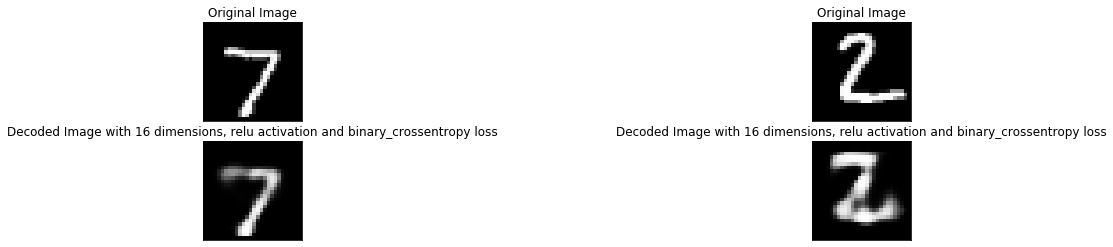

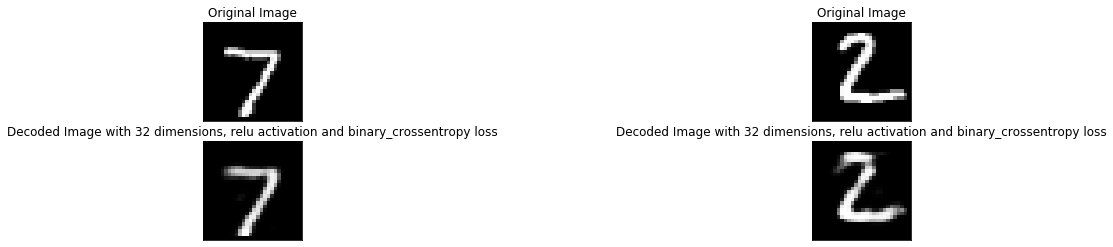

In [16]:
load_and_plot_comparison(dimension_list,'relu','binary_crossentropy',2)

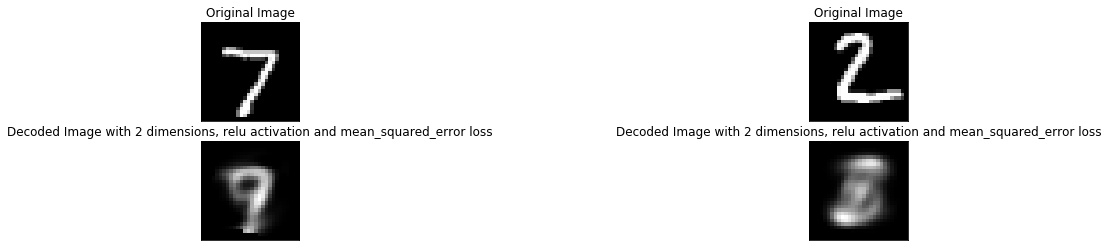

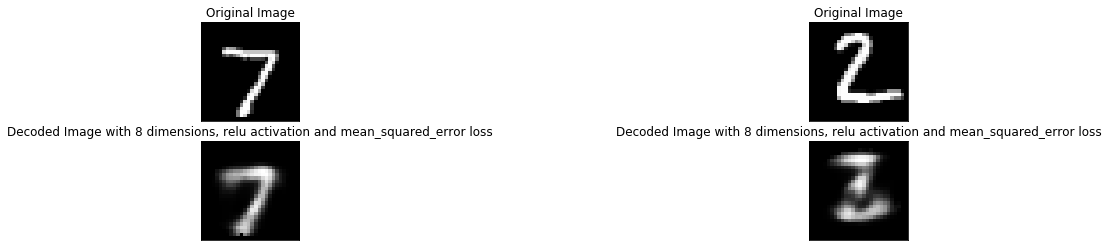

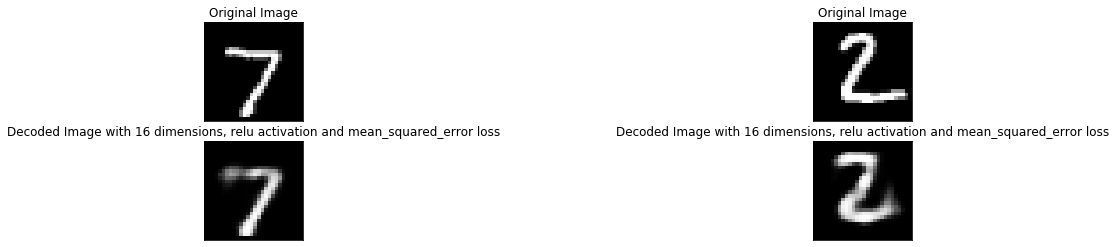

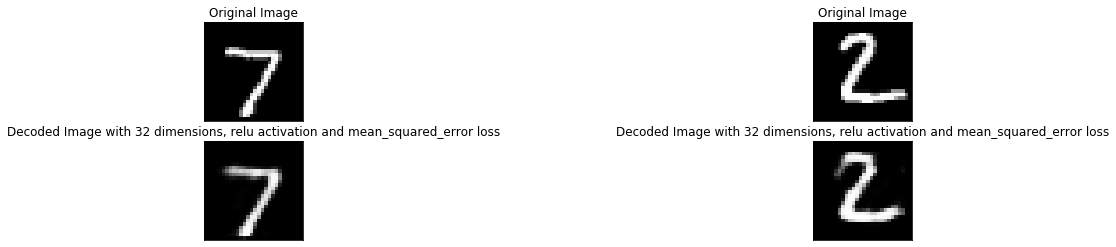

In [17]:
load_and_plot_comparison(dimension_list,'relu','mean_squared_error',2)

> _**c) Para verificar la calidad de la representación obtenida, implemente el clasificador denominado $kNN$ (k-nearest neighbor): dada una imagen $x$, el clasificador busca las k = 10 imágenes de entrenamiento más similares (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes cercanas. Mida el error, en conjunto de entrenamiento y pruebas, obtenido construyendo este clasificador sobre la data reducida a través del autoencoder comparando con la representación reducida obtenida vía PCA (una técnica clásica de reducción de dimensionalidad) utilizando el mismo número de dimensiones $d'$= 2, 8, 16, 32. Considere tanto el error de reconstrucción como el desempeño en clasificación, además de comparar los tiempos medios de predicción en ambos escenarios.**_

### Acá voy a seguir solo con ReLu para el encoder <-- redactar bonito pal informe

In [18]:
def train_and_test_error(dim_list,activation,loss):
    pca_train_error = []
    pca_test_error = []
    encoder_train_error = []
    encoder_test_error = []
    pca_time_list = []
    encoder_time_list = []
    for dim in dim_list:
        #PCA
        x_train_for_pca = x_train.reshape((len(x_train),img_rows * img_cols * channel))
        x_test_for_pca = x_test.reshape((len(x_test),img_rows * img_cols * channel))
        pca_model = PCA(n_components = dim)
        pca_model.fit(x_train_for_pca)
        start_time = time.time()
        x_pca_train = pca_model.transform(x_train_for_pca)
        x_pca_test = pca_model.transform(x_test_for_pca)
        #KNN over PCA
        knn_model = KNN(10)
        knn_model.fit(x_pca_train,y_train)
        pca_train_error.append(1 - knn_model.score(x_pca_train,y_train))
        pca_test_error.append(1 - knn_model.score(x_pca_test,y_test))
        pca_time_list.append(time.time() - start_time)
        #Encoder
        encoder = load_model("autoencoders/basic_autoencoders/%s/%s_encoder_d%s.h5" % (loss,activation,dim))
        start_time = time.time()
        x_encoder_train = encoder.predict(x_train)
        x_encoder_test = encoder.predict(x_test)
        #KNN over encoder
        knn_model = KNN(10)
        knn_model.fit(x_encoder_train,y_train)
        encoder_train_error.append(1 - knn_model.score(x_encoder_train,y_train))
        encoder_test_error.append(1 - knn_model.score(x_encoder_test,y_test))
        encoder_time_list.append(time.time() - start_time)
    return pca_train_error, pca_test_error, encoder_train_error, encoder_test_error, pca_time_list, encoder_time_list    

In [24]:
def error_plot(dim_list,activation,loss):
    pca_train, pca_test, encoder_train, encoder_test, pca_time, encoder_time = train_and_test_error(dimension_list,activation,loss)
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    plt.title("Classification Error in Train Set")
    plt.xlabel("Error",fontsize=15)
    plt.ylabel("Dimension",fontsize=15)
    plt.barh(dim_list,pca_train,0.5,color='lightcoral',label="PCA",tick_label=['2','8','16','32'])
    plt.barh(list(map(lambda x : x - 0.5,dim_list)),encoder_train,0.5,color='skyblue',label="Encoder",tick_label=['2','8','16','32'])
    plt.yticks([1.75,3.75,5.75,7.75])
    plt.legend(loc="upper right")
    plt.subplot(1,2,2)
    plt.title("Classification Error in Test Set")
    plt.xlabel("Error",fontsize=15)
    plt.ylabel("Dimension",fontsize=15)
    plt.barh(dim_list,pca_test,0.5,color='lightcoral',label="PCA",tick_label=['2','8','16','32'])
    plt.barh(list(map(lambda x : x - 0.5,dim_list)),encoder_test,0.5,color='skyblue',label="Encoder",tick_label=['2','8','16','32'])
    plt.yticks([1.75,3.75,5.75,7.75])
    plt.legend(loc="upper right")
    plt.show()
    plt.figure(figsize=(15,7))
    plt.title("Prediction times")
    plt.xlabel("Time [s]", fontsize=15)
    plt.ylabel("Dimension", fontsize=15)
    plt.barh(dim_list,pca_time,0.5,color='lightcoral',label='PCA',tick_label=['2','8','16','32'])
    plt.barh(list(map(lambda x : x - 0.5,dim_list)),encoder_time,0.5,color='skyblue',label="Encoder",tick_label=['2','8','16','32'])
    plt.yticks([1.75,3.75,5.75,7.75])
    plt.legend(loc="upper right")
    plt.show()
    

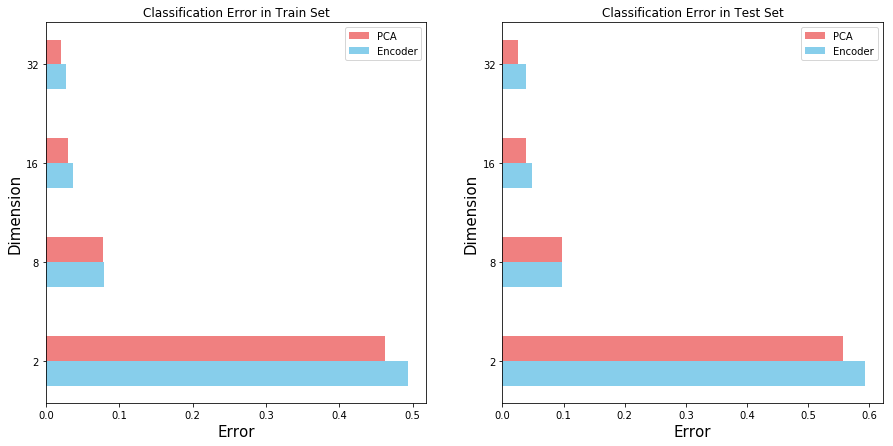

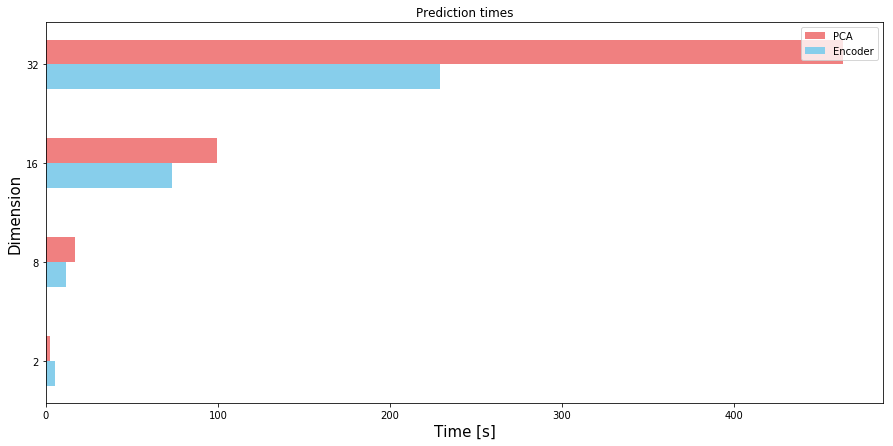

In [25]:
error_plot([2,4,6,8],'relu','binary_crossentropy')

In [ ]:
# display a 2D plot of the digit classes in the latent space
# def dim_latent_space_plot(encoder,autoencoder,x_test,y_test)
#     z = encoder.predict(x_test,
#     batch_size=batch_size)
#     plt.figure(figsize=(12, 10))
#     plt.scatter(z[:, 0], z[:, 1], c=y_test)
#     plt.colorbar()
#     plt.xlabel("z[0]")
#     plt.ylabel("z[1]")
#     plt.show()
#     # display a 30x30 2D manifold of the digits
#     n = 30
#     digit_size = 28
#     figure = np.zeros((digit_size * n, digit_size * n))
#     # linearly spaced coordinates corresponding to the 2D plot
#     # of digit classes in the latent space
#     grid_x = np.linspace(-4, 4, n)
#     grid_y = np.linspace(-4, 4, n)[::-1]
#     for i, yi in enumerate(grid_y):
#     for j, xi in enumerate(grid_x):
#     z = np.array([[xi, yi]])
#     x_decoded = decoder.predict(z)
#     digit = x_decoded[0].reshape(digit_size, digit_size)
#     figure[i * digit_size: (i + 1) * digit_size,
#            j * digit_size: (j + 1) * digit_size] = digit
#     plt.figure(figsize=(10, 10))
#     start_range = digit_size // 2
#     end_range = n * digit_size + start_range + 1
#     pixel_range = np.arange(start_range, end_range, digit_size)
#     sample_range_x = np.round(grid_x, 1)
#     sample_range_y = np.round(grid_y, 1)
#     plt.xticks(pixel_range, sample_range_x)
#     plt.yticks(pixel_range, sample_range_y)
#     plt.xlabel("z[0]")
#     plt.ylabel("z[1]")
#     plt.imshow(figure, cmap='Greys_r')
#     plt.show()


> _**d) Modifique el autoencoder básico construido en (a) para implementar un *deep autoencoder* (más de dos capas) haciendo uso de las capas convolucionales para trabajar sobre matrices. Comente cómo sufre las transformaciones el patrón de entrada. Demuestre experimentalmente que este autoencoder puede mejorar la compresión obtenida por PCA y por el obtenido en (a) utilizando el mismo número de dimensiones $d'$ . Considere en esta comparación tanto el error de reconstrucción como el desempeño en clasificación (vı́a kNN) de cada representación. Comente.**_

In [86]:
def get_conv_deepAE(compres_dim,activation,activation_decoder,loss):
    input_img = Input(shape=original_img_size)
    print(original_img_size)
    x = Conv2D(16, (3,3),activation=activation,padding='same')(input_img)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(32, (3, 3), activation=activation, padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    before_flatten = (x.shape[1].value,x.shape[2].value,x.shape[3].value)
    x = Flatten()(x)
    encode = Dense(compres_dim,activation = activation)(x)
    x = Dense(np.prod(before_flatten),activation=activation)(encode)
    x = Reshape(before_flatten)(x)
    x = Conv2D(32, (3,3), activation=activation, padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(16, (3,3), activation=activation, padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decode = Conv2D(1, (3,3), activation=activation_decoder,padding='same')(x)
    autoencoder = Model(input_img,decode)
    encoder = Model(inputs=input_img,outputs=encode)
    autoencoder.compile(optimizer='rmsprop',loss=loss)
    test_loss = autoencoder.fit(x_train,x_train,epochs=40,batch_size=32,verbose=0,validation_data=(x_test,x_test)).history['val_loss']
    return encoder, autoencoder, test_loss
    

In [87]:
def train_and_save_deepAE(dimension_list,activation_encoder,activation_decoder,loss):
    hist_list = []
    for i in dimension_list:
        encoder, autoencoder, test_loss = get_conv_deepAE(compres_dim=i,activation=activation_encoder,activation_decoder=activation_decoder,loss=loss)
        hist_list.append(test_loss)
        autoencoder.summary()
        autoencoder.save('autoencoders/deep_autoencoders/%s/%s_autoencoder_d%s.h5' % (loss,activation_encoder,i))
        encoder.save('autoencoders/deep_autoencoders/%s/%s_encoder_d%s.h5' % (loss,activation_encoder,i))
    return hist_list

In [ ]:
#NO CORRER
deep_binary = train_and_save_deepAE(dimension_list,'relu','sigmoid','binary_crossentropy')

(28, 28, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 3138     